Step 1: Load the MNIST dataset

In [1]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size_train = 64
batch_size_test = 1000
n_epochs = 3


def loadDataSets():
    trainingdataset = datasets.MNIST(root='./data', train=True,
                                     download=True,
                                     transform=transforms.Compose([transforms.ToTensor()]))

    global traindata
    traindata = torch.utils.data.DataLoader(trainingdataset, batch_size=batch_size_train, shuffle=True)

    testdataset = datasets.MNIST(root='./data', train=False,
                                 download=True,
                                 transform=transforms.Compose([transforms.ToTensor()]))

    global testdata
    testdata = torch.utils.data.DataLoader(testdataset, batch_size=batch_size_test, shuffle=True)


loadDataSets()



Step 2: Plot a subset of the Dataset

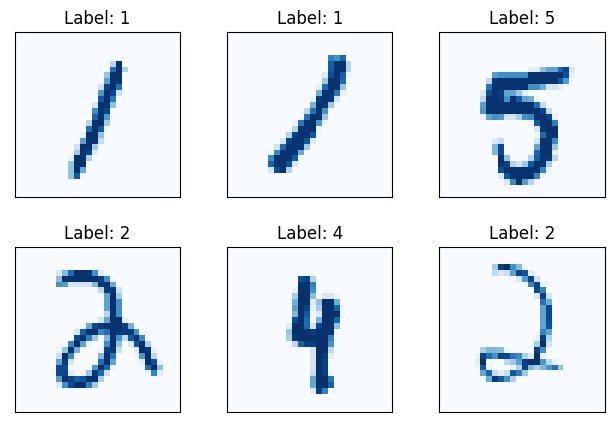

In [2]:
import matplotlib.pyplot as plt

examples = enumerate(traindata)
_, (exampledata, exampletargets) = next(examples)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(exampledata[i][0], cmap='Blues', interpolation='none')
    plt.title("Label: {}".format(exampletargets[i]))
    plt.xticks([])
    plt.yticks([])


Step 3: Construct Model

In [3]:
import torch
from torch import nn


class CNN(torch.nn.Module):
    def __init__(self, initweights=False, usebias=False, hiddenunits=128):
        self.hiddenunits = hiddenunits
        self.usebias = usebias
        super(CNN, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1,
                                bias=self.usebias)

        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1,
                                bias=self.usebias)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        self.linear_1 = nn.Linear(1568, self.hiddenunits, bias=self.usebias)
        self.linear_2 = nn.Linear(self.hiddenunits, self.hiddenunits * 2, bias=self.usebias)
        self.linear_3 = nn.Linear(self.hiddenunits * 2, 10, bias=self.usebias)

        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        if initweights:
            nn.init.kaiming_normal_(self.conv_1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_normal_(self.conv_2.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_normal_(self.linear_1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_normal_(self.linear_2.weight, mode='fan_in', nonlinearity='relu')
            nn.init.xavier_normal_(self.linear_3.weight)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.sigmoid(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.sigmoid(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.sigmoid(x)
        x = self.linear_2(x)
        x = self.sigmoid(x)
        x = self.linear_3(x)

        return self.softmax(x)


loss_fn = nn.CrossEntropyLoss()


def initializeModel(learning_rate, initweight=False, initbias=False, hiddenunits=128):
    global cnn
    cnn = CNN(initweight, initbias, hiddenunits)

    print(f"CNN model: {cnn}")

    global loss_fn
    loss_fn = nn.CrossEntropyLoss()

    global optimizer
    optimizer = torch.optim.Adam(params=cnn.parameters(), lr=learning_rate)



Step 4: Training the Model

In [37]:
log_interval = 10
trainlosses = []
traincounter = []
testlosses = []
testcounter = [i * len(traindata.dataset) for i in range(n_epochs + 1)]


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    cnn.to(device)

    cnn.train()
    total_train_loss = 0
    totaltrainlosses = []
    totaltrainaccu = []

    for epoch in range(num_epochs):

        correct = 0
        total = 0
        for itr, (image, label) in enumerate(traindata):
            optimizer.zero_grad()
            cnnoutput = cnn(image)
            loss = loss_fn(cnnoutput, label)


            lossitem = loss.item()
            total_train_loss += lossitem

            predicted = cnnoutput.max(1)[1]
            correct += predicted.eq(label).sum().item()
            total += label.size(0)

            loss.backward()
            optimizer.step()

            if itr % log_interval == 0:
                print('Training Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, itr * len(image),
                                                                                  len(traindata.dataset),
                                                                                  100. * itr / len(traindata),
                                                                                  loss.item()))
                trainlosses.append(lossitem)
                traincounter.append((itr * 64) + ((epoch - 1) * len(traindata.dataset)))

        accu = 100. * correct / total
        computedloss = total_train_loss / (itr + 1)
        totaltrainaccu.append(accu)
        print(f"Total training loss for epoch : {epoch} loss: {computedloss} accuracy: {accu}")
        totaltrainlosses.append(computedloss)
        total_train_loss = 0
        accu = 0
        correct = 0
        total = 0

    aggregateloss = 0
    aggregateaccu = 0
    for indloss in totaltrainlosses:
        aggregateloss += indloss
    for taccu in totaltrainaccu:
        aggregateaccu += taccu
    print(f"Total training loss across epochs : {num_epochs} loss: {aggregateloss/num_epochs} accuracy: {aggregateaccu/num_epochs}")



Step 5: Hyperparameter Tuning with GridSearchCV

In [5]:
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV


def optimize():
    lr = 0.001
    epochs = 3
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    net = NeuralNetClassifier(
        module=CNN, max_epochs=epochs,
        optimizer=torch.optim.Adam,
        train_split=None,
        criterion=loss_fn,
        lr=lr, verbose=0)

    params = {
        'lr': [0.001, 0.01, 0.005],
        'max_epochs': [1, 3, 5],
        'module__hiddenunits': [32, 64, 128],
        'module__usebias': [False, True],
        'module__initweights': [False, True]
    }

    gs = GridSearchCV(
        net, params, refit=False, scoring='accuracy', verbose=1, cv=2, error_score='raise'
    )

    counter = 0
    nobatches = 2

    for data in traindata:
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        gs.fit(image, labels)
        if counter == nobatches:
            break

    print(f"optimized params: {gs.best_params_}")
    return gs



Step 6: Test Model

In [6]:
def test():
    cnn.eval()
    totalloss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in traindata:
            cnnoutput = cnn(data)

            loss = loss_fn(cnnoutput, target)
            lossitem = loss.item()
            totalloss += lossitem

            predicted = cnnoutput.max(1)[1]
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    testloss = totalloss / len(traindata)
    accu = 100. * correct / total

    testlosses.append(testloss)

    print('Testing Loss: %.3f | Accuracy: %.3f' % (testloss, accu))



Step7: Optimize with GridSearchCV

In [41]:
best = optimize()

lr = best.best_params_['lr']
initweights = best.best_params_['module__initweights']
usebias = best.best_params_['module__usebias']
hiddenunits = best.best_params_['module__hiddenunits']

print("Initializing Neural Network with GridSearchCV Params...")
print("lr: {}, initweights: {}, usebias: {}, hiddenunits: {}".format(lr, initweights, usebias, hiddenunits))

initializeModel(lr, initweights, usebias, hiddenunits)

trainlosses = []
traincounter = []
testlosses = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

Fitting 2 folds for each of 108 candidates, totalling 216 fits
Fitting 2 folds for each of 108 candidates, totalling 216 fits
optimized params: {'lr': 0.001, 'max_epochs': 1, 'module__hiddenunits': 128, 'module__initweights': True, 'module__usebias': False}
Initializing Neural Network with GridSearchCV Params...
lr: 0.001, initweights: True, usebias: False, hiddenunits: 128
CNN model: CNN(
  (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1568, out_features=128, bias=False)
  (linear_2): Linear(in_features=128, out_features=256, bias=False)
  (linear_3): Linear(in_features=256, out_features=10, bias=False)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)
Testing Loss: 2.311 | Accuracy: 9.872
Training Epoch: 0 [0/60000 (0%)]	Loss: 2.2

Step 8: Experiment 1

In [38]:
initializeModel(0.001, False, False, 64)

trainlosses = []
traincounter = []
testlosses = []

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

CNN model: CNN(
  (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1568, out_features=64, bias=False)
  (linear_2): Linear(in_features=64, out_features=128, bias=False)
  (linear_3): Linear(in_features=128, out_features=10, bias=False)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)
Testing Loss: 2.303 | Accuracy: 9.930
Training Epoch: 0 [0/60000 (0%)]	Loss: 2.306560
Training Epoch: 0 [640/60000 (1%)]	Loss: 2.298435
Training Epoch: 0 [1280/60000 (2%)]	Loss: 2.308378
Training Epoch: 0 [1920/60000 (3%)]	Loss: 2.293922
Training Epoch: 0 [2560/60000 (4%)]	Loss: 2.306113
Training Epoch: 0 [3200/60000 (5%)]	Loss: 2.308174
Training Epoch: 0 [3840/60000 (6%)]	Loss: 2.300500
Training Epoch: 0 [4480/60000 (7%)]	Loss: 2.289921
Training Epoch: 0

Step 9: Experiment 2

In [39]:
initializeModel(0.01, True, True, 32)

trainlosses = []
traincounter = []
testlosses = []

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

CNN model: CNN(
  (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1568, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=64, bias=True)
  (linear_3): Linear(in_features=64, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)
Testing Loss: 2.305 | Accuracy: 9.930
Training Epoch: 0 [0/60000 (0%)]	Loss: 2.284933
Training Epoch: 0 [640/60000 (1%)]	Loss: 2.287762
Training Epoch: 0 [1280/60000 (2%)]	Loss: 2.295399
Training Epoch: 0 [1920/60000 (3%)]	Loss: 2.308936
Training Epoch: 0 [2560/60000 (4%)]	Loss: 2.320493
Training Epoch: 0 [3200/60000 (5%)]	Loss: 2.287565
Training Epoch: 0 [3840/60000 (6%)]	Loss: 2.309692
Training Epoch: 0 [4480/60000 (7%)]	Loss: 2.311176
Training Epoch: 0 [5120/60000 (9%)]	Loss: 2.31

Step 10: Show Model Performance

Text(0, 0.5, 'loss')

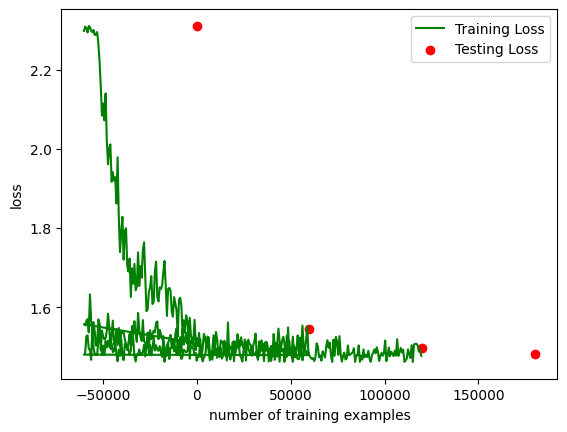

In [42]:

plt.plot(traincounter, trainlosses, color='green')
plt.scatter(testcounter, testlosses, color='red')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.xlabel('number of training examples')
plt.ylabel('loss')




Step 11: Show prediction

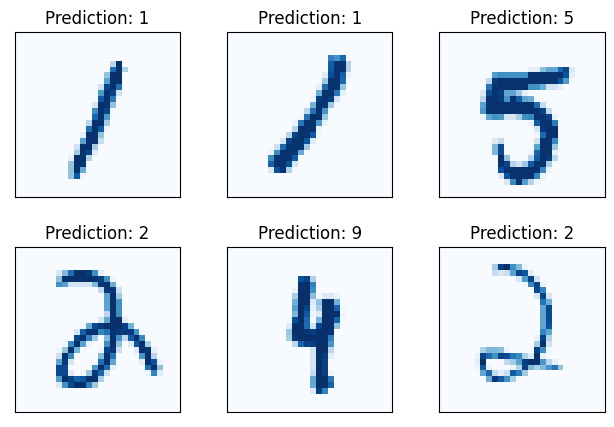

In [43]:
with torch.no_grad():
  output = cnn(exampledata)

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(exampledata[i][0], cmap='Blues', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])